In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
#Dados fornecidos no enunciado
Lx = 1 #dimensão em x
Ly = 1 #dimensão em y
k = 1 #W/mk
NVRx = 11 #quantidade de volumes reais em x
NVRy = 11 #quantidade de volumes reais em y
Nx = NVRx + 2 #quantidade de volumes de controle em x considerando os volumes fictícios
Ny = NVRy + 2 #quantidade de volumes de controle em y considerando os volumes fictícios
qtdadeVolumes = Nx * Ny #quantidade total de volumes de controle
deltaX = Lx / NVRx #distância do centro de um volume ao outro em x
deltaY = Ly / NVRy #distância do centro de um volume ao outro em y

x = np.linspace(deltaX/2, Lx - deltaX/2, NVRx) #coordenadas dos centros dos volumes de controle em x
y = np.linspace(deltaY/2, Ly - deltaY/2, NVRy) #coordenadas dos centros dos volumes de controle em y
Tx1 = np.sin(np.pi * x) #temperatura na parede superior
T0y = 0 #temperatura na parede esquerda
T1y = 0 #temperatura na parede direita
Tx0 = 0 #temperatura na parede inferior

print('x = ', x, '\n'
      'y = ', y, '\n'
      'Tx1 = ', Tx1)

x =  [0.04545455 0.13636364 0.22727273 0.31818182 0.40909091 0.5
 0.59090909 0.68181818 0.77272727 0.86363636 0.95454545] 
y =  [0.04545455 0.13636364 0.22727273 0.31818182 0.40909091 0.5
 0.59090909 0.68181818 0.77272727 0.86363636 0.95454545] 
Tx1 =  [0.14231484 0.41541501 0.65486073 0.84125353 0.95949297 1.
 0.95949297 0.84125353 0.65486073 0.41541501 0.14231484]


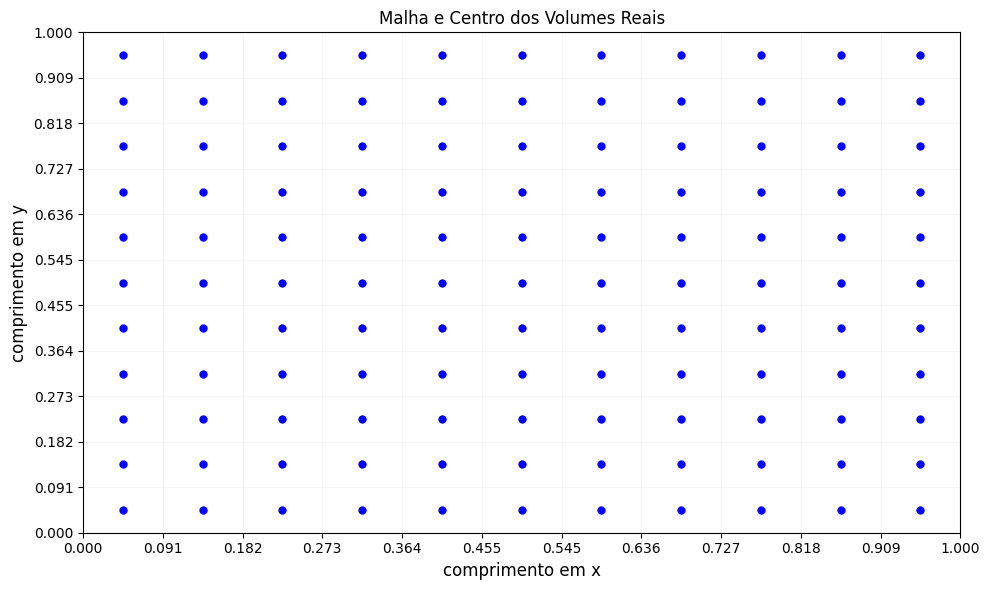

In [17]:
plt.figure(figsize=(10,6))
for i in range(0, len(x)):
    for k in range(0, len(y)):
        plt.plot(x[i], y[k], color='blue', linestyle='None', linewidth=2, marker='o', markersize=5)
plt.xticks(np.arange(0, 1 + 1/11, 1/11))
plt.yticks(np.arange(0, 1 + 1/11, 1/11))
plt.xlabel('comprimento em x', fontsize=12)
plt.ylabel('comprimento em y', fontsize=12)
plt.title('Malha e Centro dos Volumes Reais', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=.1)
plt.tight_layout()
plt.show()

In [18]:
Tn = np.zeros(Nx)
Tn[1: -1] = np.sin(np.pi * x) #temperatura na parede norte
Ts = np.zeros(Nx) #temperatura na parede sul
Tw = np.zeros(Ny) #temperatura na parede oeste
Te = np.zeros(Ny) #temperatura na parede leste


In [19]:
def coeficientes(Nx, Ny, Tw, Te, Ts, Tn):

    #criando as matrizes de coeficientes inicialmente preenchidas com zeros
    aW = np.zeros((Ny, Nx), dtype=np.float64)
    aE = np.zeros((Ny, Nx), dtype=np.float64)
    aS = np.zeros((Ny, Nx), dtype=np.float64)
    aN = np.zeros((Ny, Nx), dtype=np.float64)
    aP = np.zeros((Ny, Nx), dtype=np.float64)
    b = np.zeros((Ny, Nx), dtype=np.float64)

    #índices para os volumes internos
    y_interno = slice(1, Ny - 1) #usaremos i para as linhas, varendo os volumes na direção y
    x_interno = slice(1, Nx - 1) #usaremos x_leste para as colunas, varendo os volumes na direção x

    aW[y_interno, x_interno] = 1
    aE[y_interno, x_interno] = 1
    aS[y_interno, x_interno] = 1
    aN[y_interno, x_interno] = 1
    
    aP[y_interno, x_interno] = 4
    b[y_interno, x_interno] = 0
    
    #para o contorno oeste
    x_oeste = 0
    
    aW[y_interno, x_oeste] = 0.0
    aE[y_interno, x_oeste] = -1.0
    aS[y_interno, x_oeste] = 0.0
    aN[y_interno, x_oeste] = 0.0
    aP[y_interno, x_oeste] = 1.0
    b[y_interno, x_oeste] = 2.0 * Tw[y_interno]

    #para o contorno leste
    x_leste = Nx - 1 #-1 pq o índice começa em 0
    
    aW[y_interno, x_leste] = -1.0
    aE[y_interno, x_leste] = 0.0
    aS[y_interno, x_leste] = 0.0
    aN[y_interno, x_leste] = 0.0
    aP[y_interno, x_leste] = 1.0
    b[y_interno, x_leste] = 2.0 * Te[y_interno]
    
    #contorno sul
    y_sul = 0
    
    aW[y_sul, x_interno] = 0.0
    aE[y_sul, x_interno] = 0.0
    aS[y_sul, x_interno] = 0.0
    aN[y_sul, x_interno] = -1.0
    aP[y_sul, x_interno] = 1.0
    b[y_sul, x_interno] = 2.0 * Ts[x_interno]

    #contorno norte
    y_norte  = Ny - 1 #-1 pq o índice começa em 0
    
    aW[y_norte, x_interno] = 0.0
    aE[y_norte, x_interno] = 0.0
    aS[y_norte, x_interno] = -1.0
    aN[y_norte, x_interno] = 0.0
    aP[y_norte, x_interno] = 1.0
    b[y_norte, x_interno] = 2.0 * Tn[x_interno]

    return aW, aE, aS, aN, aP, b

In [21]:
def solucao_analitica(x_in, y_in, Lx, Ly):
    pi = np.arccos(-1.0)
    term_x = np.sin(pi * x_in / Lx)
    term_y = np.sinh(pi * y_in / Lx)
    denom = np.sinh(pi * Ly / Lx)
    return term_x * term_y / denom

def solver_gs_com_historico(Nx, Ny, aW, aE, aS, aN, aP, b, To, max_iter, tol):
    T = np.full((Ny, Nx), To, dtype=np.float64)
    historico = []
    
    i_cent = Ny // 2
    j_cent = Nx // 2
    
    iteracao = 0
    norma_residuos = float('inf')
    
    while iteracao < max_iter:
        T_old_center = T[i_cent, j_cent]
        
        for i in range(1, Ny - 1):
            for j in range(1, Nx - 1):
                soma_vizinhos = (aW[i, j] * T[i, j - 1] + aE[i, j] * T[i, j + 1] +
                                 aS[i, j] * T[i - 1, j] + aN[i, j] * T[i + 1, j])
                T[i, j] = (soma_vizinhos + b[i, j]) / (aP[i, j])
        
        T[1:Ny-1, 0] = b[1:Ny-1, 0] / 2.0      
        T[1:Ny-1, Nx-1] = b[1:Ny-1, Nx-1] / 2.0 
        T[0, 1:Nx-1] = b[0, 1:Nx-1] / 2.0      
        T[Ny-1, 1:Nx-1] = b[Ny-1, 1:Nx-1] / 2.0 

        diff_central = np.abs(T[i_cent, j_cent] - T_old_center)
        historico.append(diff_central)
        
        res = 0.0
        for i in range(1, Ny-1):
            for j in range(1, Nx-1):
                viz = (aW[i,j]*T[i,j-1] + aE[i,j]*T[i,j+1] + aS[i,j]*T[i-1,j] + aN[i,j]*T[i+1,j])
                res += np.abs(viz + b[i,j] - aP[i,j]*T[i,j])
        
        if iteracao > 0 and res < tol:
            print(f"Convergência em {iteracao} iterações. Erro final: {res:.2e}")
            break
            
        iteracao += 1
        
    return T, historico, iteracao

Tw = np.zeros(Ny); Te = np.zeros(Ny); Ts = np.zeros(Nx); Tn = np.zeros(Nx)
dx_real = Lx / (Nx - 2) 
for j in range(1, Nx - 1):
    x_val = (j - 0.5) * dx_real 
    Tn[j] = np.sin(np.pi * x_val / Lx)

aW, aE, aS, aN, aP, b = coeficientes(Nx, Ny, Tw, Te, Ts, Tn)
aP = np.abs(aP) 

T_final, hist_central, num_iters = solver_gs_com_historico(Nx, Ny, aW, aE, aS, aN, aP, b, To=0.0, max_iter=20000, tol=1e-12)

Convergência em 415 iterações. Erro final: 9.36e-13


In [22]:
def plotar_mapa_calor(Nx, Ny, Lx, Ly, T_solucao, titulo="Distribuição de Temperatura 2D (Gauss-Seidel)"):

    T_interna = T_solucao[1:Ny - 1, 1:Nx - 1]
    

    dx = Lx / (Nx - 2.0)
    dy = Ly / (Ny - 2.0)

    x_edges = np.linspace(0.0, Lx, Nx - 1)
    y_edges = np.linspace(0.0, Ly, Ny - 1)

    x_c = np.linspace(0, Lx, Nx - 1) # Cantos das células internas em x
    y_c = np.linspace(0, Ly, Ny - 1) # Cantos das células internas em y
    
    plt.figure(figsize=(9, 8))
    
    vmin = T_solucao.min()
    vmax = T_solucao.max()
    
    X, Y = np.meshgrid(x_c, y_c)

    x_total = np.linspace(-dx/2, Lx + dx/2, Nx + 1)
    y_total = np.linspace(-dy/2, Ly + dy/2, Ny + 1)
    X_tot, Y_tot = np.meshgrid(x_total, y_total)

    im = plt.pcolormesh(X_tot, Y_tot, T_solucao, shading='flat', cmap='coolwarm', vmin=vmin, vmax=vmax)

    plt.title(titulo, fontsize=14)
    plt.xlabel('Comprimento em x', fontsize=12)
    plt.ylabel('Comprimento em y', fontsize=12)
    
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    
    cbar = plt.colorbar(im, label='Temperatura (T)', orientation='vertical', shrink=0.8)
    for xc in x_c:
        plt.axvline(x=xc, color='k', linestyle='--', linewidth=0.5, alpha=0.3)

    for yc in y_c:
        plt.axhline(y=yc, color='k', linestyle='--', linewidth=0.5, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
    
    return

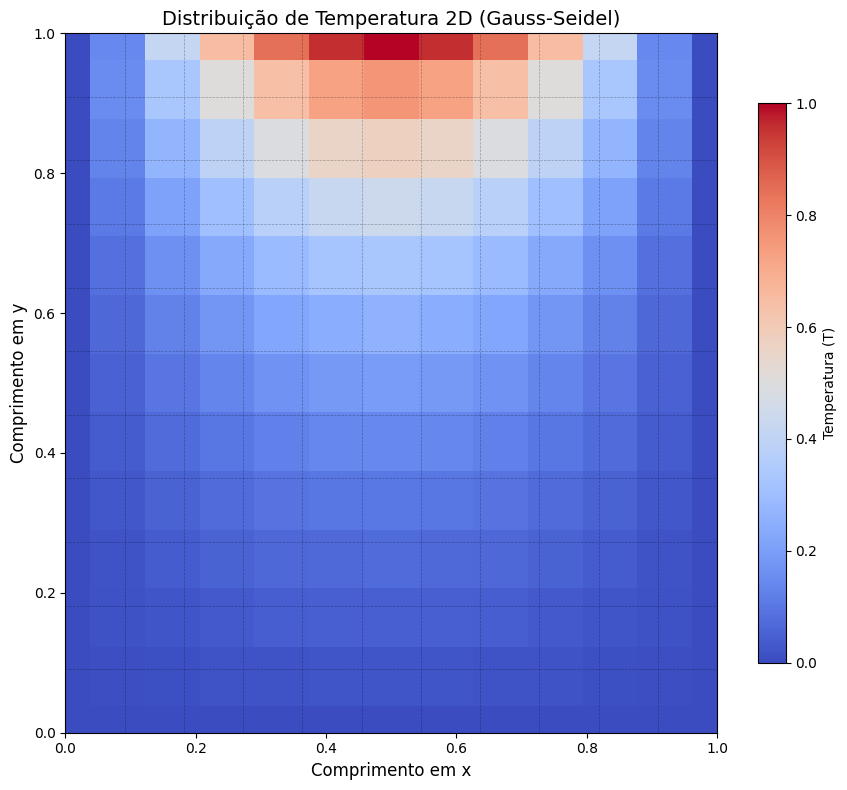

In [23]:
plotar_mapa_calor(Nx, Ny, Lx, Ly, T_final)

1) Número de iterações para atingir a tolerância (erro máquina ~1e-12): 415


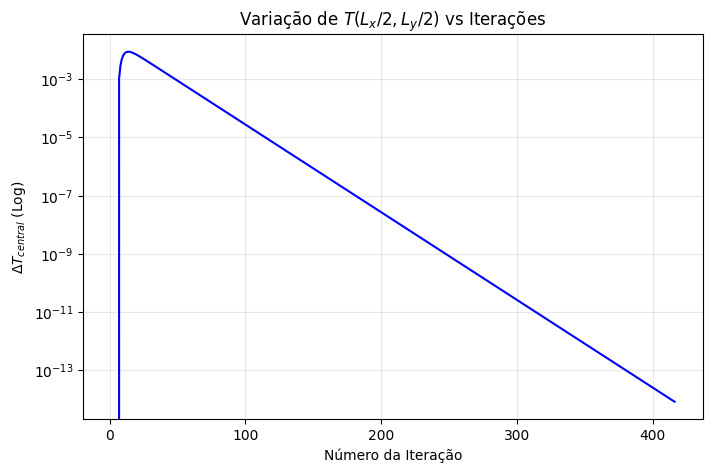

In [24]:
#ITEM 1
# Célula 1: Gráfico da Variação de T no centro
print(f"1) Número de iterações para atingir a tolerância (erro máquina ~1e-12): {num_iters}")

plt.figure(figsize=(8, 5))
iters = np.arange(1, len(hist_central) + 1)
# O enunciado pede escala logarítmica para variação (y) e decimal para iteração (x)
plt.semilogy(iters, hist_central, 'b-', linewidth=1.5)
plt.title(r"Variação de $T(L_x/2, L_y/2)$ vs Iterações")
plt.xlabel("Número da Iteração")
plt.ylabel(r"$\Delta T_{central}$ (Log)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [26]:
#ITEM 2
j_mid = (Nx - 1) // 2
x_loc = (j_mid - 0.5) * (Lx/(Nx-2)) 

print(f"2) Tabela de resultados para a linha vertical em x ≈ {x_loc:.3f} (Índice j={j_mid})")

dados_x_meio = []

for i in range(Ny):
    if i == 0: y_val = 0.0 
    elif i == Ny-1: y_val = Ly 
    else: y_val = (i - 0.5) * (Ly/(Ny-2))
    
    t_num = T_final[i, j_mid]
    t_ana = solucao_analitica(x_loc, y_val, Lx, Ly)
    erro = t_ana - t_num
    
    dados_x_meio.append([y_val, t_ana, t_num, erro])

df_x_meio = pd.DataFrame(dados_x_meio, columns=["Posição Y", "T Analítico", "T Numérico", "Erro"])
display(df_x_meio.round(6))

2) Tabela de resultados para a linha vertical em x ≈ 0.500 (Índice j=6)


,Posição Y,T Analítico,T Numérico,Erro
0,0.000000,0.000000,0.000000,0.000000
1,0.045455,0.012407,0.022160,-0.009753
2,0.136364,0.038240,0.045838,-0.007598
3,0.227273,0.067213,0.072658,-0.005444
4,0.318182,0.101706,0.104468,-0.002761
5,0.409091,0.144552,0.143480,0.001072
6,0.500000,0.199268,0.192439,0.006829
7,0.590909,0.270349,0.254861,0.015488
8,0.681818,0.363632,0.335349,0.028283
9,0.772727,0.486778,0.440061,0.046717


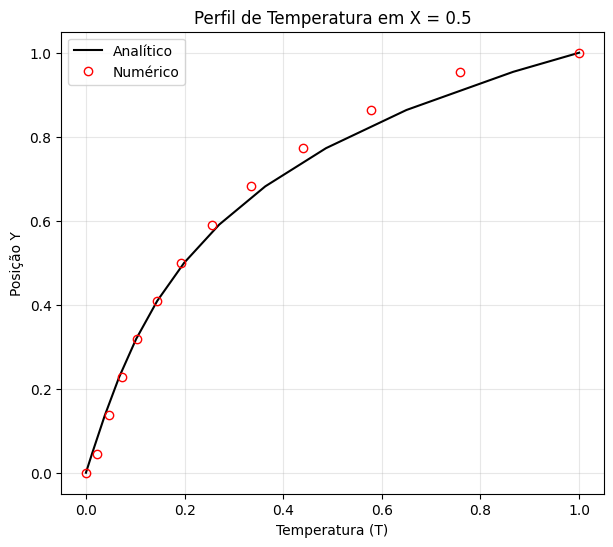

In [27]:
#ITEM 3
plt.figure(figsize=(7, 6))
plt.plot(df_x_meio["T Analítico"], df_x_meio["Posição Y"], 'k-', label='Analítico')
plt.plot(df_x_meio["T Numérico"], df_x_meio["Posição Y"], 'ro', fillstyle='none', label='Numérico')
plt.title(f"Perfil de Temperatura em X = {Lx/2}")
plt.xlabel("Temperatura (T)")
plt.ylabel("Posição Y")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [29]:
#ITEM 4
i_mid = (Ny - 1) // 2
y_loc = (i_mid - 0.5) * (Ly/(Ny-2))

print(f"4) Tabela de resultados para a linha horizontal em y ≈ {y_loc:.3f} (Índice i={i_mid})")

dados_y_meio = []

for j in range(Nx):
    if j == 0: x_val = 0.0 
    elif j == Nx-1: x_val = Lx 
    else: x_val = (j - 0.5) * (Lx/(Nx-2))
    
    t_num = T_final[i_mid, j]
    t_ana = solucao_analitica(x_val, y_loc, Lx, Ly)
    erro = t_ana - t_num
    
    dados_y_meio.append([x_val, t_ana, t_num, erro])

df_y_meio = pd.DataFrame(dados_y_meio, columns=["Posição X", "T Analítico", "T Numérico", "Erro"])
display(df_y_meio.round(6))

4) Tabela de resultados para a linha horizontal em y ≈ 0.500 (Índice i=6)


,Posição X,T Analítico,T Numérico,Erro
0,0.000000,0.000000,0.000000,0.000000
1,0.045455,0.028359,0.049058,-0.020699
2,0.136364,0.082779,0.095099,-0.012320
3,0.227273,0.130493,0.135063,-0.004570
4,0.318182,0.167635,0.166061,0.001574
5,0.409091,0.191197,0.185709,0.005488
6,0.500000,0.199268,0.192439,0.006829
7,0.590909,0.191197,0.185709,0.005488
8,0.681818,0.167635,0.166061,0.001574
9,0.772727,0.130493,0.135063,-0.004570


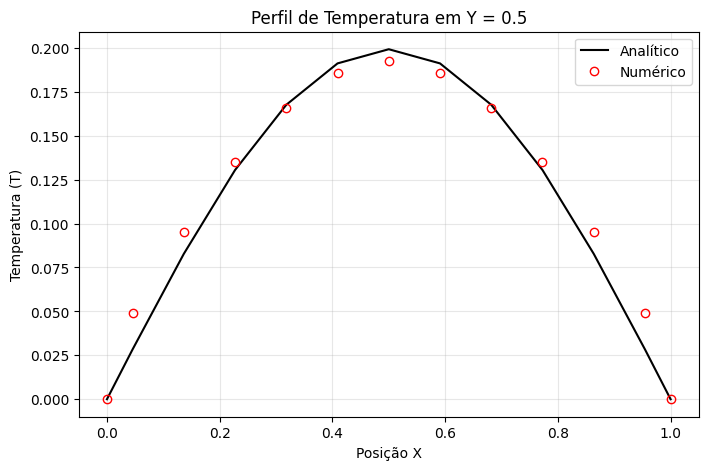

In [30]:
#ITEM 5
plt.figure(figsize=(8, 5))
plt.plot(df_y_meio["Posição X"], df_y_meio["T Analítico"], 'k-', label='Analítico')
plt.plot(df_y_meio["Posição X"], df_y_meio["T Numérico"], 'ro', fillstyle='none', label='Numérico')
plt.title(f"Perfil de Temperatura em Y = {Ly/2}")
plt.xlabel("Posição X")
plt.ylabel("Temperatura (T)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [31]:
#ITEM 6
# Analítica (Fórmula baseada no arquivo Fortran pos_processamento)
# Tman = 2.0*Lx*( cosh(pi*Ly/Lx)-1.0 ) / ( (pi**2)*Ly*sinh(pi*Ly/Lx) )
pi = np.pi
T_med_analitica = (2.0 * Lx * (np.cosh(pi*Ly/Lx) - 1.0)) / ((pi**2) * Ly * np.sinh(pi*Ly/Lx))

# Numérica (Regra do retângulo: média aritmética dos volumes internos)
# Apenas volumes internos (1 a Ny-2, 1 a Nx-2)
T_internos = T_final[1:Ny-1, 1:Nx-1]
T_med_numerica = np.mean(T_internos)

erro_media = T_med_analitica - T_med_numerica

print("6) Comparação da Temperatura Média")
print(f"   T Média Analítica: {T_med_analitica:.6f} °C")
print(f"   T Média Numérica : {T_med_numerica:.6f} °C")
print(f"   Erro             : {erro_media:.6f} °C")

6) Comparação da Temperatura Média
   T Média Analítica: 0.185854 °C
   T Média Numérica : 0.180573 °C
   Erro             : 0.005281 °C


In [ ]:
#ITEM 7
# Analítica (Do Fortran: qea = k*( cosh(pi*Ly/Lx)-1.0 ) / sinh(pi*Ly/Lx))
q_leste_analitico = k * (np.cosh(pi*Ly/Lx) - 1.0) / np.sinh(pi*Ly/Lx)

# Q = -k * A * dT/dx
dx = Lx / (Nx - 2)
dy = Ly / (Ny - 2)
q_leste_numerico = 0.0

for i in range(1, Ny-1):
    T_face = T_final[i, Nx-1] 
    T_no   = T_final[i, Nx-2] 
    # q = -k * (dT/dx) * Area_face
    q_cell = -k * (T_face - T_no) / (dx/2.0) * dy
    q_leste_numerico += q_cell

erro_leste = q_leste_analitico - q_leste_numerico

print("7) Taxa de Transferência de Calor - Contorno Leste [W]")
print(f"   Q Leste Analítico: {q_leste_analitico:.6f}")
print(f"   Q Leste Numérico : {q_leste_numerico:.6f}")
print(f"   Erro             : {erro_leste:.6f}")

7) Taxa de Transferência de Calor - Contorno Leste [W]
   Q Leste Analítico: 9.171523
   Q Leste Numérico : 13.721502
   Erro             : -4.549979


In [32]:
#ITEM 8
# Analítica (qna = -2.0*k*cosh(pi*Ly/Lx)/sinh(pi*Ly/Lx))
q_norte_analitico = -2.0 * k * np.cosh(pi*Ly/Lx) / np.sinh(pi*Ly/Lx)

q_norte_numerico = 0.0

for j in range(1, Nx-1):
    T_face = T_final[Ny-1, j] 
    T_no   = T_final[Ny-2, j] 
    # Gradiente na face norte: (T_face - T_no) / (dy/2)
    # Lei de Fourier q = -k * dT/dy * Area (dx)
    q_cell = -k * (T_face - T_no) / (dy/2.0) * dx
    q_norte_numerico += q_cell

erro_norte = q_norte_analitico - q_norte_numerico

print("8) Taxa de Transferência de Calor - Contorno Norte [W]")
print(f"   Q Norte Analítico: {q_norte_analitico:.6f}")
print(f"   Q Norte Numérico : {q_norte_numerico:.6f}")
print(f"   Erro             : {erro_norte:.6f}")

8) Taxa de Transferência de Calor - Contorno Norte [W]
   Q Norte Analítico: -20.074837
   Q Norte Numérico : -30.806756
   Erro             : 10.731919
